In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("plotting.mplstyle")
import numpy as np
import sys
sys.path.append("./../code/")
from population_model import massModel,truncatedNormal
from tqdm import tqdm

cbbh = '#1f78b4'
cnsbh = '#33a02c'
cbns = '#e31a1c'
cmisc = '#6a3d9a'

In [3]:
inj_data = az.from_netcdf("../data/output_standardInjections.cdf")
injA_data = az.from_netcdf("../data/output_standardInjections_injectionSubsetA.cdf")
injB_data = az.from_netcdf("../data/output_standardInjections_injectionSubsetB.cdf")

nn_data = az.from_netcdf("../data/output_dynamicInjections.cdf")
nnA_data = az.from_netcdf("../data/output_dynamicInjections_altNetwork_03.cdf")
nnB_data = az.from_netcdf("../data/output_dynamicInjections_altNetwork_17.cdf")
nnC_data = az.from_netcdf("../data/output_dynamicInjections_altNetwork_28.cdf")
nnD_data = az.from_netcdf("../data/output_dynamicInjections_altNetwork_67.cdf")

In [4]:
inj_samps = inj_data.posterior.stack(draws=("chain", "draw"))
injA_samps = injA_data.posterior.stack(draws=("chain", "draw"))
injB_samps = injB_data.posterior.stack(draws=("chain", "draw"))

nn_samps = nn_data.posterior.stack(draws=("chain", "draw"))
nnA_samps = nnA_data.posterior.stack(draws=("chain", "draw"))
nnB_samps = nnB_data.posterior.stack(draws=("chain", "draw"))
nnC_samps = nnC_data.posterior.stack(draws=("chain", "draw"))
nnD_samps = nnD_data.posterior.stack(draws=("chain", "draw"))

In [5]:
nDraws = 3000

In [6]:
m_grid = np.linspace(2,100,500)
q_grid = np.linspace(0,1,499)
z_grid = np.linspace(0,1.5,500)
M,Q = np.meshgrid(m_grid,q_grid)
chi_grid = np.linspace(0,1,500)
cost_grid = np.linspace(-1,1,500)

def process(samps):
    
    R_zs = np.zeros((nDraws,z_grid.size))
    p_ms = np.zeros((nDraws,m_grid.size))
    p_qs = np.zeros((nDraws,q_grid.size))
    p_chis = np.zeros((nDraws,chi_grid.size))
    p_costs = np.zeros((nDraws,cost_grid.size))
    
    for i in tqdm(range(nDraws)):

        p_m = massModel(m_grid,
                        samps.alpha.values[i],
                        samps.mu_m1.values[i],
                        samps.sig_m1.values[i],
                        10.**samps.log_f_peak.values[i],
                        samps.mMax.values[i],
                        samps.mMin.values[i],
                        10.**samps.log_dmMax.values[i],
                        10.**samps.log_dmMin.values[i])

        p_m_ref = massModel(20.,
                        samps.alpha.values[i],
                        samps.mu_m1.values[i],
                        samps.sig_m1.values[i],
                        10.**samps.log_f_peak.values[i],
                        samps.mMax.values[i],
                        samps.mMin.values[i],
                        10.**samps.log_dmMax.values[i],
                        10.**samps.log_dmMin.values[i])
    
        R_zs[i,:] = samps.R20.values[i]*np.trapz(p_m/p_m_ref,m_grid)*((1.+z_grid)/(1.+0.2))**samps.kappa.values[i]


        p_m = massModel(M,
                        samps.alpha.values[i],
                        samps.mu_m1.values[i],
                        samps.sig_m1.values[i],
                        10.**samps.log_f_peak.values[i],
                        samps.mMax.values[i],
                        samps.mMin.values[i],
                        10.**samps.log_dmMax.values[i],
                        10.**samps.log_dmMin.values[i])

        # Construct 2D NN distribution
        bq = samps.bq.values[i]
        p_q = (1.+bq)*Q**bq/(1.-(2./M)**(1.+bq))
        p_q[Q<=2/M] = 0
        p_2D = p_m*p_q

        # Marginalize
        p_m = np.sum(p_2D,axis=0)
        p_ms[i,:] = p_m/np.trapz(p_m,m_grid)
        p_q = np.sum(p_2D,axis=1)
        p_qs[i,:] = p_q/np.trapz(p_q,q_grid)
            
        p_chi = truncatedNormal(chi_grid,
                    samps.mu_chi.values[i],
                    10.**samps.logsig_chi.values[i],
                    0,1)
        
        p_chis[i,:] = p_chi/np.trapz(p_chi,chi_grid)
        
        f_iso = samps.f_iso.values[i]
        p_cost = f_iso*(1./2.) \
            + (1.-f_iso)*truncatedNormal(cost_grid, samps.mu_cost.values[i], samps.sig_cost.values[i], -1, 1)

        p_costs[i,:] = p_cost/np.trapz(p_cost,cost_grid)
        
    return R_zs, p_ms, p_qs, p_chis, p_costs

In [7]:
R_zs_inj, p_ms_inj, p_qs_inj, p_chis_inj, p_costs_inj = process(inj_samps)
R_zs_injA, p_ms_injA, p_qs_injA, p_chis_injA, p_costs_injA = process(injA_samps)
R_zs_injB, p_ms_injB, p_qs_injB, p_chis_injB, p_costs_injB = process(injB_samps)

  0%|                                                                                                                                                                | 0/3000 [00:00<?, ?it/s]/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_12099/945320765.py:53: RuntimeWarning: divide by zero encountered in divide
  p_q = (1.+bq)*Q**bq/(1.-(2./M)**(1.+bq))
/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_12099/945320765.py:53: RuntimeWarning: invalid value encountered in divide
  p_q = (1.+bq)*Q**bq/(1.-(2./M)**(1.+bq))
  1%|▉                                                                                                                                                      | 18/3000 [00:00<01:02, 47.80it/s]/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_12099/945320765.py:53: RuntimeWarning: divide by zero encountered in power
  p_q = (1.+bq)*Q**bq/(1.-(2./M)**(1.+bq))
100%|███████████████████████████████████████████████████████████████████████████████████

In [8]:
R_zs_nn, p_ms_nn, p_qs_nn, p_chis_nn, p_costs_nn = process(nn_samps)
R_zs_nnA, p_ms_nnA, p_qs_nnA, p_chis_nnA, p_costs_nnA = process(nnA_samps)
R_zs_nnB, p_ms_nnB, p_qs_nnB, p_chis_nnB, p_costs_nnB = process(nnB_samps)
R_zs_nnC, p_ms_nnC, p_qs_nnC, p_chis_nnC, p_costs_nnC = process(nnC_samps)
R_zs_nnD, p_ms_nnD, p_qs_nnD, p_chis_nnD, p_costs_nnD = process(nnD_samps)

  0%|                                                                                                                                                                | 0/3000 [00:00<?, ?it/s]/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_12099/945320765.py:53: RuntimeWarning: divide by zero encountered in divide
  p_q = (1.+bq)*Q**bq/(1.-(2./M)**(1.+bq))
/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_12099/945320765.py:53: RuntimeWarning: invalid value encountered in divide
  p_q = (1.+bq)*Q**bq/(1.-(2./M)**(1.+bq))
  2%|██▍                                                                                                                                                    | 48/3000 [00:00<00:37, 78.08it/s]/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_12099/945320765.py:53: RuntimeWarning: divide by zero encountered in power
  p_q = (1.+bq)*Q**bq/(1.-(2./M)**(1.+bq))
100%|███████████████████████████████████████████████████████████████████████████████████

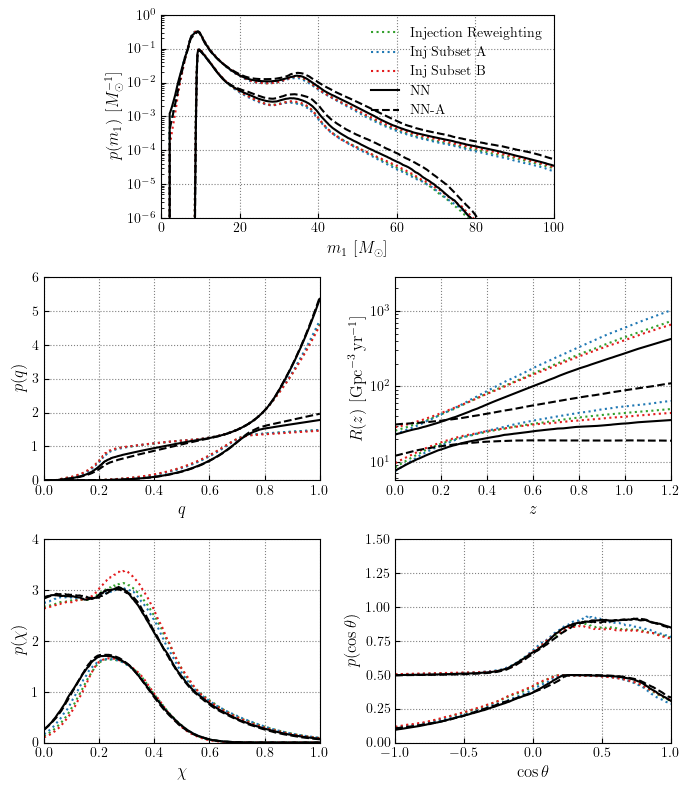

In [12]:
fig = plt.figure(figsize=(7.,8))

## Primary mass
ax = plt.subplot2grid(shape=(3, 6), loc=(0, 1), colspan=4)

ax.plot(m_grid,np.quantile(p_ms_inj,0.05,axis=0),color=cnsbh,lw=1.5,label='Injection Reweighting',ls=':')
ax.plot(m_grid,np.quantile(p_ms_inj,0.95,axis=0),color=cnsbh,lw=1.5,ls=':')
ax.plot(m_grid,np.quantile(p_ms_injA,0.05,axis=0),color=cbbh,lw=1.5,label='Inj Subset A',ls=':')
ax.plot(m_grid,np.quantile(p_ms_injA,0.95,axis=0),color=cbbh,lw=1.5,ls=':')
ax.plot(m_grid,np.quantile(p_ms_injB,0.05,axis=0),color=cbns,lw=1.5,label='Inj Subset B',ls=':')
ax.plot(m_grid,np.quantile(p_ms_injB,0.95,axis=0),color=cbns,lw=1.5,ls=':')
ax.plot(m_grid,np.quantile(p_ms_nn,0.05,axis=0),color='black',lw=1.5,label='NN')
ax.plot(m_grid,np.quantile(p_ms_nn,0.95,axis=0),color='black',lw=1.5)
ax.plot(m_grid,np.quantile(p_ms_nnD,0.05,axis=0),color='black',ls='--',lw=1.5,label='NN-A')
ax.plot(m_grid,np.quantile(p_ms_nnD,0.95,axis=0),color='black',ls='--',lw=1.5)
#ax.plot(m_grid,np.quantile(p_ms_nnD,0.05,axis=0),color='black',ls='-.',lw=1.5,label='NN-B')
#ax.plot(m_grid,np.quantile(p_ms_nnD,0.95,axis=0),color='black',ls='-.',lw=1.5)
ax.set_yscale('log')
ax.set_xlim(0,100)
ax.set_ylim(1e-6,1)
ax.set_xlabel('$m_1$ $[M_\odot]$')
ax.set_ylabel('$p(m_1)$ $[M_\odot^{-1}]$')
ax.legend(loc='upper right')

## Mass ratio
ax = plt.subplot2grid(shape=(3, 6), loc=(1, 0), colspan=3)

ax.plot(q_grid,np.quantile(p_qs_inj,0.05,axis=0),color=cnsbh,lw=1.5,ls=':')
ax.plot(q_grid,np.quantile(p_qs_inj,0.95,axis=0),color=cnsbh,lw=1.5,ls=':')
ax.plot(q_grid,np.quantile(p_qs_injA,0.05,axis=0),color=cbbh,lw=1.5,ls=':')
ax.plot(q_grid,np.quantile(p_qs_injA,0.95,axis=0),color=cbbh,lw=1.5,ls=':')
ax.plot(q_grid,np.quantile(p_qs_injB,0.05,axis=0),color=cbns,lw=1.5,ls=':')
ax.plot(q_grid,np.quantile(p_qs_injB,0.95,axis=0),color=cbns,lw=1.5,ls=':')
ax.plot(q_grid,np.quantile(p_qs_nn,0.05,axis=0),color='black',lw=1.5)
ax.plot(q_grid,np.quantile(p_qs_nn,0.95,axis=0),color='black',lw=1.5)
ax.plot(q_grid,np.quantile(p_qs_nnD,0.05,axis=0),color='black',lw=1.5,ls='--')
ax.plot(q_grid,np.quantile(p_qs_nnD,0.95,axis=0),color='black',lw=1.5,ls='--')
#ax.plot(q_grid,np.quantile(p_qs_nnD,0.05,axis=0),color='black',lw=1.5,ls='-.')
#ax.plot(q_grid,np.quantile(p_qs_nnD,0.95,axis=0),color='black',lw=1.5,ls='-.')
ax.set_xlim(0,1)
ax.set_ylim(0,6)
ax.set_xlabel('$q$')
ax.set_ylabel('$p(q)$')

## Redshift
ax = plt.subplot2grid(shape=(3, 6), loc=(1, 3), colspan=3)

ax.plot(z_grid,np.quantile(R_zs_inj,0.05,axis=0),color=cnsbh,lw=1.5,ls=':')
ax.plot(z_grid,np.quantile(R_zs_inj,0.95,axis=0),color=cnsbh,lw=1.5,ls=':')
ax.plot(z_grid,np.quantile(R_zs_injA,0.05,axis=0),color=cbbh,lw=1.5,ls=':')
ax.plot(z_grid,np.quantile(R_zs_injA,0.95,axis=0),color=cbbh,lw=1.5,ls=':')
ax.plot(z_grid,np.quantile(R_zs_injB,0.05,axis=0),color=cbns,lw=1.5,ls=':')
ax.plot(z_grid,np.quantile(R_zs_injB,0.95,axis=0),color=cbns,lw=1.5,ls=':')
ax.plot(z_grid,np.quantile(R_zs_nn,0.05,axis=0),color='black',lw=1.5)
ax.plot(z_grid,np.quantile(R_zs_nn,0.95,axis=0),color='black',lw=1.5)
ax.plot(z_grid,np.quantile(R_zs_nnD,0.05,axis=0),color='black',lw=1.5,ls='--')
ax.plot(z_grid,np.quantile(R_zs_nnD,0.95,axis=0),color='black',lw=1.5,ls='--')
#ax.plot(z_grid,np.quantile(R_zs_nnD,0.05,axis=0),color='black',lw=1.5,ls='-.')
#ax.plot(z_grid,np.quantile(R_zs_nnD,0.95,axis=0),color='black',lw=1.5,ls='-.')
ax.set_yscale('log')
ax.set_xlim(0,1.2)
ax.set_xlabel('$z$')
ax.set_ylabel('$R(z)$ $[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}]$')

## Spin magnitude
ax = plt.subplot2grid(shape=(3, 6), loc=(2, 0), colspan=3)

ax.plot(chi_grid,np.quantile(p_chis_inj,0.05,axis=0),color=cnsbh,lw=1.5,ls=':')
ax.plot(chi_grid,np.quantile(p_chis_inj,0.95,axis=0),color=cnsbh,lw=1.5,ls=':')
ax.plot(chi_grid,np.quantile(p_chis_injA,0.05,axis=0),color=cbbh,lw=1.5,ls=':')
ax.plot(chi_grid,np.quantile(p_chis_injA,0.95,axis=0),color=cbbh,lw=1.5,ls=':')
ax.plot(chi_grid,np.quantile(p_chis_injB,0.05,axis=0),color=cbns,lw=1.5,ls=':')
ax.plot(chi_grid,np.quantile(p_chis_injB,0.95,axis=0),color=cbns,lw=1.5,ls=':')
ax.plot(chi_grid,np.quantile(p_chis_nn,0.05,axis=0),color='black',lw=1.5)
ax.plot(chi_grid,np.quantile(p_chis_nn,0.95,axis=0),color='black',lw=1.5)
ax.plot(chi_grid,np.quantile(p_chis_nnD,0.05,axis=0),color='black',lw=1.5,ls='--')
ax.plot(chi_grid,np.quantile(p_chis_nnD,0.95,axis=0),color='black',lw=1.5,ls='--')
#ax.plot(chi_grid,np.quantile(p_chis_nnD,0.05,axis=0),color='black',lw=1.5,ls='-.')
#ax.plot(chi_grid,np.quantile(p_chis_nnD,0.95,axis=0),color='black',lw=1.5,ls='-.')
ax.set_xlabel('$\chi$')
ax.set_ylabel('$p(\chi)$')
ax.set_xlim(0,1)
ax.set_ylim(0,4)

## Spin tilt
ax = plt.subplot2grid(shape=(3, 6), loc=(2, 3), colspan=3)

ax.plot(cost_grid,np.quantile(p_costs_inj,0.05,axis=0),color=cnsbh,lw=1.5,ls=':')
ax.plot(cost_grid,np.quantile(p_costs_inj,0.95,axis=0),color=cnsbh,lw=1.5,ls=':')
ax.plot(cost_grid,np.quantile(p_costs_injA,0.05,axis=0),color=cbbh,lw=1.5,ls=':')
ax.plot(cost_grid,np.quantile(p_costs_injA,0.95,axis=0),color=cbbh,lw=1.5,ls=':')
ax.plot(cost_grid,np.quantile(p_costs_injB,0.05,axis=0),color=cbns,lw=1.5,ls=':')
ax.plot(cost_grid,np.quantile(p_costs_injB,0.95,axis=0),color=cbns,lw=1.5,ls=':')
ax.plot(cost_grid,np.quantile(p_costs_nn,0.05,axis=0),color='black',lw=1.5)
ax.plot(cost_grid,np.quantile(p_costs_nn,0.95,axis=0),color='black',lw=1.5)
ax.plot(cost_grid,np.quantile(p_costs_nnD,0.05,axis=0),color='black',lw=1.5,ls='--')
ax.plot(cost_grid,np.quantile(p_costs_nnD,0.95,axis=0),color='black',lw=1.5,ls='--')
#ax.plot(cost_grid,np.quantile(p_costs_nnD,0.05,axis=0),color='black',lw=1.5,ls='-.')
#ax.plot(cost_grid,np.quantile(p_costs_nnD,0.95,axis=0),color='black',lw=1.5,ls='-.')
ax.set_xlabel('$\cos\\theta$')
ax.set_ylabel('$p(\cos\\theta)$')
ax.set_xlim(-1,1)
ax.set_ylim(0,1.5)

plt.tight_layout()
#plt.savefig('inj_subset_results.pdf',bbox_inches='tight')
plt.show()

In [9]:
from astropy.cosmology import Planck15
import astropy.units as u

In [60]:
reference_z_grid = np.linspace(0.,1.9,1000)
reference_dVdz_grid = 4.*np.pi*Planck15.differential_comoving_volume(reference_z_grid).to(u.Gpc**3/u.sr).value
dz = np.diff(reference_z_grid)[0]

In [65]:
inj_z_cdfs = np.random.uniform(0,1,10000)

inj_kappa = -2
reference_f_z = reference_dVdz_grid*(1.+reference_z_grid)**(inj_kappa-1.)
reference_cdf_z = np.cumsum(reference_f_z)*dz
reference_f_z_integral = reference_cdf_z[-1]
reference_cdf_z /= reference_f_z_integral
inj_z = np.interp(inj_z_cdfs, reference_cdf_z, reference_z_grid)

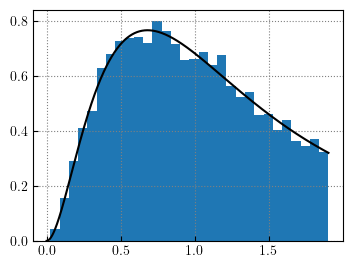

In [66]:
new_z_grid = np.linspace(0,1.9,10000)
new_dVdz_grid = 4.*np.pi*Planck15.differential_comoving_volume(new_z_grid).to(u.Gpc**3/u.sr).value
p_z = new_dVdz_grid*(1.+new_z_grid)**(inj_kappa-1)
p_z /= np.trapz(p_z,new_z_grid)

fig,ax = plt.subplots()
ax.hist(inj_z,bins=30,density=True)
ax.plot(new_z_grid,p_z,color='black')
plt.show()